In [110]:
import os
import random
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image, ImageEnhance
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [105]:
df = pd.read_csv('../DATASETS/weights.csv')
df.head()

,name,path,weight_kg
0,Citroen_C3_2025_.jpg,IMAGES\HatchBack\Citroen_C3_2025_.jpg,NaN
1,Citroen_C4_2025_.jpg,IMAGES\HatchBack\Citroen_C4_2025_.jpg,NaN
2,Fiat_500_2025_.jpg,IMAGES\HatchBack\Fiat_500_2025_.jpg,NaN
3,Opel_Astra_2025_.jpg,IMAGES\HatchBack\Opel_Astra_2025_.jpg,NaN
4,Skoda_Fabia_2025_.jpg,IMAGES\HatchBack\Skoda_Fabia_2025_.jpg,NaN


In [106]:
def overexpose_image(image, value):
    enhancer = ImageEnhance.Brightness(image)
    overexposed_image = enhancer.enhance(value)
    return overexposed_image

def overexpose_image_random(image):
    overxposing_factor = random.uniform(1.3, 2.5)
    improved_image = overexpose_image(image, overxposing_factor)
    return improved_image, True, overxposing_factor - 1.3

# Settings
source_dir = Path('../DATASETS/RIA_BY_CLASSES_CROPPED_ROTATED')
dest_dir = Path('../DATASETS/overbrightened')
col1 = 'overexposed'
col2 = 'degree'
csv_path = '../DATASETS/brightness_log.csv'

def create_dataset(source_dir, dest_dir, csv_path, col1, col2, mod_func):
    
    records = []
    
    for subfolder in source_dir.iterdir():
        if subfolder.is_dir():
            images = list(subfolder.glob('*'))
            images = [img for img in images if img.suffix.lower() in ['.jpg']]
    
            # Select 50% randomly
            n_to_process = len(images) // 2
            selected_images = random.sample(images, n_to_process)
            selected_set = set(selected_images)
    
            for img_path in tqdm(images, desc=f'Processing {subfolder.name}', leave=True):
                # Open the image
                img = Image.open(img_path)
    
                # Prepare the destination path
                relative_subfolder = img_path.parent.relative_to(source_dir)
                dest_subfolder = dest_dir / relative_subfolder
                dest_subfolder.mkdir(parents=True, exist_ok=True)
    
                dest_path = dest_subfolder / img_path.name
    
                if img_path in selected_set:
                    # Improve the image
                    improved_img, overexposed, degree_of_brightness = mod_func(img)
                    improved_img.save(dest_path)
                    records.append({
                        'image_path': str(dest_path),
                        col1: overexposed,
                        col2: degree_of_brightness
                    })
                else:
                    # Just copy the image
                    shutil.copy(img_path, dest_path)
                    records.append({
                        'image_path': str(dest_path),
                        col1: False,
                        col2: 0
                    })
    
    # Create a DataFrame
    df = pd.DataFrame(records)
    
    # Save the DataFrame as CSV (optional)
    df.to_csv(csv_path, index=False)
    
    print("Done!", len(records), "images processed.")
    return df
    
df = create_dataset(source_dir, dest_dir, csv_path, col1, col2, overexpose_image_random)
df

Processing HatchBack:   0%|          | 0/418 [00:00<?, ?it/s]

Processing MiniVan and MicroVan:   0%|          | 0/433 [00:00<?, ?it/s]

Processing PickUp:   0%|          | 0/310 [00:00<?, ?it/s]

Processing Sedan:   0%|          | 0/408 [00:00<?, ?it/s]

Processing SUV, Crossover:   0%|          | 0/433 [00:00<?, ?it/s]

Done! 2002 images processed.


,image_path,overexposed,degree
0,..\DATASETS\overbrightened\HatchBack\Citroen_C...,True,1.115405
1,..\DATASETS\overbrightened\HatchBack\Citroen_C...,True,0.999934
2,..\DATASETS\overbrightened\HatchBack\Fiat_500_...,True,0.963197
3,..\DATASETS\overbrightened\HatchBack\Opel_Astr...,False,0.000000
4,..\DATASETS\overbrightened\HatchBack\Skoda_Fab...,False,0.000000
...,...,...,...
1997,"..\DATASETS\overbrightened\SUV, Crossover\Поза...",True,0.308424
1998,"..\DATASETS\overbrightened\SUV, Crossover\Поза...",False,0.000000
1999,"..\DATASETS\overbrightened\SUV, Crossover\Поза...",False,0.000000
2000,"..\DATASETS\overbrightened\SUV, Crossover\Поза...",False,0.000000


In [107]:
print(df.head())

                                          image_path  overexposed    degree
0  ..\DATASETS\overbrightened\HatchBack\Citroen_C...         True  1.115405
1  ..\DATASETS\overbrightened\HatchBack\Citroen_C...         True  0.999934
2  ..\DATASETS\overbrightened\HatchBack\Fiat_500_...         True  0.963197
3  ..\DATASETS\overbrightened\HatchBack\Opel_Astr...        False  0.000000
4  ..\DATASETS\overbrightened\HatchBack\Skoda_Fab...        False  0.000000


In [108]:
def split_balanced(df, test_ratio=0.2, random_state=42):
    df = df.copy()
    df['class'] = df['image_path'].apply(lambda x: x.split('overbrightened\\')[1].split('\\')[0])

    train_dfs = []
    test_dfs = []
    val_dfs = []

    for vehicle_class, group in df.groupby('class'):
        if len(group) <= 2:
            # Not enough samples to split into three sets, assign to train
            train_dfs.append(group)
            continue

        temp_test_val_size = int(len(group) * test_ratio)

        if temp_test_val_size == 0:
            temp_test_val_size = 1  # ensure at least one sample if possible

        temp_df, train_split = train_test_split(
            group,
            test_size=len(group) - 2 * temp_test_val_size,
            random_state=random_state,
            shuffle=True
        )

        test_split, val_split = train_test_split(
            temp_df,
            test_size=0.5,
            random_state=random_state,
            shuffle=True
        )

        test_dfs.append(test_split)
        val_dfs.append(val_split)
        train_dfs.append(train_split)

    train_df = pd.concat(train_dfs).reset_index(drop=True)
    test_df = pd.concat(test_dfs).reset_index(drop=True)
    val_df = pd.concat(val_dfs).reset_index(drop=True)

    return train_df, test_df, val_df

train_df_, test_df_, val_df_ = split_balanced(df, test_ratio=0.2)
train_df, test_df, val_df = split_balanced(train_df_, test_ratio=0.2)
print(f"Train set size: {len(train_df_)}, Test set size: {len(test_df_)}, Validation set size: {len(val_df_)}")

Train set size: 1206, Test set size: 398, Validation set size: 398


In [109]:
# === 1. Load the datasets ===

# Assume you already have these
# train_df, test_df, val_df

# === 2. Create a PyTorch Dataset class ===

class OverexposureDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['overexposed'])

        if self.transform:
            image = self.transform(image)
        
        return image, label

# === 3. Define transformations ===

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Scales to [0,1]
])

# === 4. Create DataLoaders ===

batch_size = 32

train_dataset = OverexposureDataset(train_df, transform=transform)
test_dataset = OverexposureDataset(test_df, transform=transform)
val_dataset = OverexposureDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# === 5. Define the CNN model ===

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),  # Output between 0 and 1
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# === 6. Train the model ===

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = outputs > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {acc:.4f}')

train_model()

# === 7. Validate on test/val sets ===

def evaluate_from_dataframe(df, dataset_name='Test'):
    model.eval()
    transform_eval = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    preds = []
    true_labels = []

    with torch.no_grad():
        for idx, row in df.iterrows():
            img_path = row['image_path']
            label = int(row['overexposed'])

            # Load and preprocess image
            image = Image.open(img_path).convert('RGB')
            image = transform_eval(image)
            image = image.unsqueeze(0).to(device)  # Add batch dimension

            # Predict
            output = model(image)
            pred = (output > 0.5).item()

            preds.append(pred)
            true_labels.append(label)

    # Create a result dataframe
    result_df = df.copy()
    result_df['predicted_overexposed'] = preds
    result_df['true_overexposed'] = true_labels
    result_df['correct'] = (result_df['predicted_overexposed'] == result_df['true_overexposed'])

    acc = result_df['correct'].mean()

    print(f'{dataset_name} Accuracy: {acc:.4f}')
    return result_df

test_results = evaluate_from_dataframe(test_df, dataset_name='Test')
val_results = evaluate_from_dataframe(val_df, dataset_name='Validation')
test_results = evaluate_from_dataframe(test_df_, dataset_name='Test')
val_results = evaluate_from_dataframe(val_df_, dataset_name='Validation')

# You can now inspect wrong predictions easily:
wrong_predictions = test_results[test_results['correct'] == False]
# print(wrong_predictions[['image_path', 'true_overexposed', 'predicted_overexposed']])

Epoch 1/10, Loss: 0.4634, Accuracy: 0.7576
Epoch 2/10, Loss: 0.1796, Accuracy: 0.9394
Epoch 3/10, Loss: 0.1590, Accuracy: 0.9394
Epoch 4/10, Loss: 0.1136, Accuracy: 0.9573
Epoch 5/10, Loss: 0.0806, Accuracy: 0.9738
Epoch 6/10, Loss: 0.1312, Accuracy: 0.9545
Epoch 7/10, Loss: 0.1358, Accuracy: 0.9477
Epoch 8/10, Loss: 0.0350, Accuracy: 0.9945
Epoch 9/10, Loss: 0.0218, Accuracy: 0.9972
Epoch 10/10, Loss: 0.0126, Accuracy: 0.9986
Test Accuracy: 0.9500
Validation Accuracy: 0.9292
Test Accuracy: 0.9271
Validation Accuracy: 0.9523


In [120]:
def show_mistakes(result_df, max_images=10):
    mistakes = result_df[result_df['correct'] == False]

    if mistakes.empty:
        print("No mistakes to show. Model is perfect on this set!")
        return

    mistakes = mistakes.sample(min(len(mistakes), max_images))  # show up to max_images random mistakes

    for idx, row in mistakes.iterrows():
        img_path = row['image_path']
        true_label = row['true_overexposed']
        pred_label = row['predicted_overexposed']
        degree = row['degree']

        image = Image.open(img_path).convert('RGB')

        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"Predicted: {bool(pred_label)} | True: {bool(true_label)}, Factor: {round(degree,2)}", fontsize=14)
        plt.axis('off')
        plt.show()

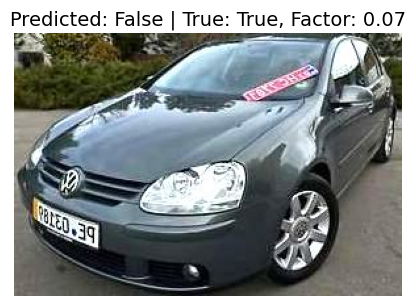

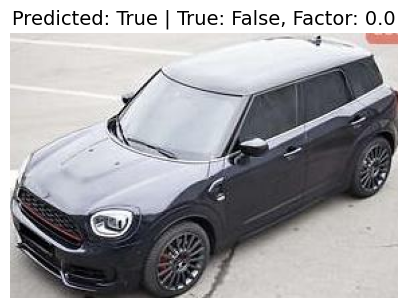

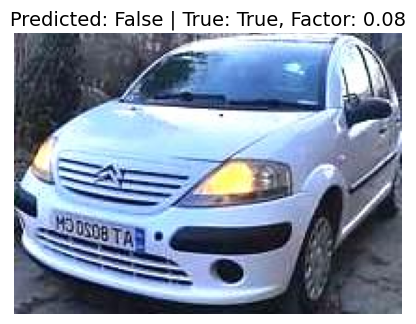

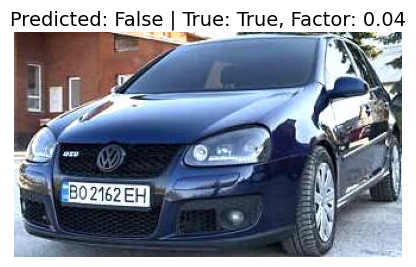

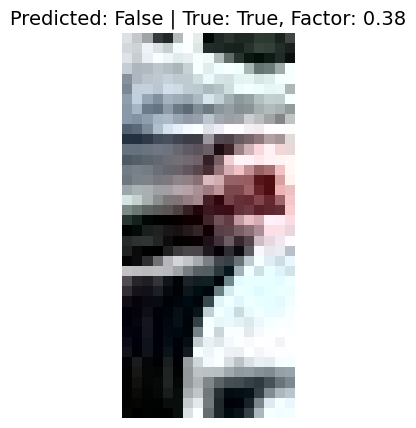

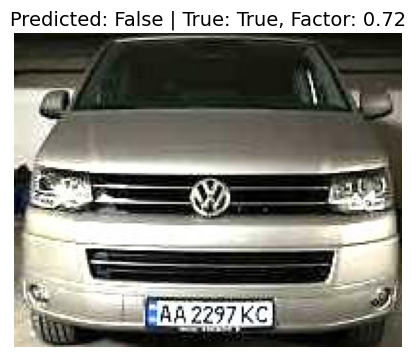

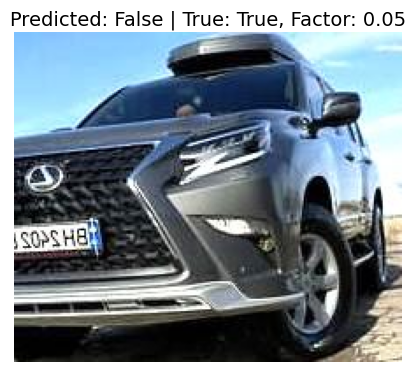

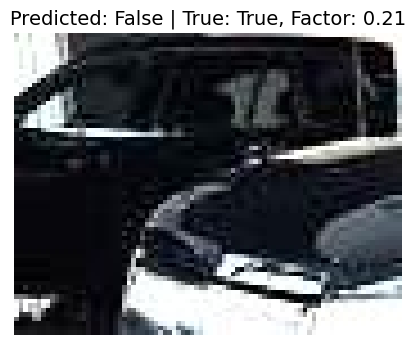

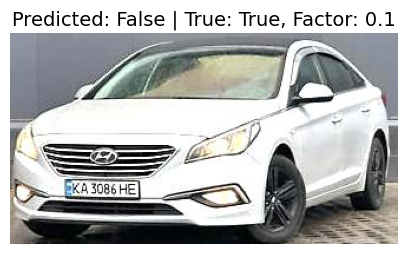

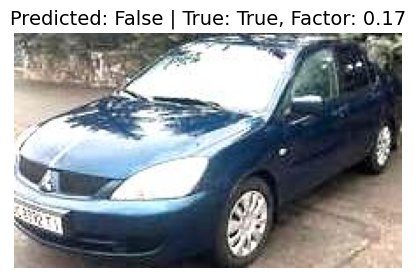

In [121]:
show_mistakes(test_results, max_images=10)